In [2]:
import sys
sys.path.append("/home/azhuavlev/PycharmProjects/ml-neuman_mano")

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import glob
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch3d
import sys
import time
import torch
from IPython import display
from PIL import Image
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)
# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from tqdm import tqdm

from generate_cow_renders import generate_cow_renders
from plot_image_grid import image_grid

from helpers import *
from nerf import *

from data_io import neuman_helper

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the data

# Datasets

In [5]:
from torch.utils.data import DataLoader
import dataset_from_files
import glob

data_path = '/home/azhuavlev/Desktop/Data/InterHand_Neuman/03'
all_ids = list(range(len(glob.glob(os.path.join(data_path, 'cameras', '*.json')))))

# use 80% of the data for training, randomize the order
np.random.shuffle(all_ids)
train_ids = all_ids[:int(0.6 * len(all_ids))]
test_ids = all_ids[int(0.6 * len(all_ids)):]
print(test_ids)

train_dataset = dataset_from_files.NeumanDataset(data_path, train_ids)
test_dataset = dataset_from_files.NeumanDataset(data_path, test_ids)
full_dataset = dataset_from_files.NeumanDataset(data_path, all_ids)

# We sample 6 random cameras in a minibatch.
batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=5)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

[34, 27, 3, 47, 26, 30, 7, 31, 48, 6, 4, 50, 28, 24, 18, 12, 38, 44, 2, 52, 45, 11, 21, 14]


In [6]:
# print example batch
example = next(iter(train_loader))
example

[{'R': tensor([[[ 0.2922,  0.0849, -0.9526],
           [-0.7792,  0.5986, -0.1857],
           [ 0.5545,  0.7965,  0.2411]]]),
  't': tensor([[1.0304, 0.1836, 0.8936]]),
  'intrinsic_mat': tensor([[[1.2842e+03, 0.0000e+00, 1.8564e+02],
           [0.0000e+00, 1.2844e+03, 2.1944e+02],
           [0.0000e+00, 0.0000e+00, 1.0000e+00]]]),
  'image_size': tensor([[512., 334.]])},
 tensor([[[[0.0157, 0.0196, 0.0000],
           [0.0196, 0.0235, 0.0039],
           [0.0235, 0.0275, 0.0078],
           ...,
           [0.0196, 0.0118, 0.0235],
           [0.0196, 0.0118, 0.0235],
           [0.0196, 0.0118, 0.0235]],
 
          [[0.0157, 0.0196, 0.0000],
           [0.0196, 0.0196, 0.0118],
           [0.0235, 0.0235, 0.0157],
           ...,
           [0.0196, 0.0118, 0.0235],
           [0.0196, 0.0118, 0.0235],
           [0.0196, 0.0118, 0.0235]],
 
          [[0.0157, 0.0157, 0.0157],
           [0.0196, 0.0196, 0.0196],
           [0.0196, 0.0196, 0.0196],
           ...,
           [

# Training loop

In [ ]:
import lighning_models
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import nerf


nerf = nerf.NeuralRadianceField()

model = lighning_models.HandModel(dataset=full_loader, nerf_model=nerf)

output_dir = '/home/azhuavlev/Desktop/Results/neuman_custom/'
logger = TensorBoardLogger(output_dir)

trainer = L.Trainer(
    max_epochs=3001,
    benchmark=True,
    logger=logger,
    default_root_dir=output_dir,
    check_val_every_n_epoch=100,
    log_every_n_steps=25,
    callbacks=[],
)
trainer.fit(
    model,
    train_loader,
    full_loader,
)

In [7]:
import lighning_models
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import nerf
import dataset_canonical_space

nerf = nerf.NeuralRadianceField()

ckpt_path = '/home/azhuavlev/Desktop/Results/neuman_custom/lightning_logs/version_128/checkpoints/epoch=649-step=23400.ckpt'
model = lighning_models.HandModel(dataset=full_loader, nerf_model=nerf).load_from_checkpoint(ckpt_path, dataset=full_loader, nerf_model=nerf)

can_dataset = dataset_canonical_space.CanSpaceDataset(n_cameras=20)
can_dataloader = DataLoader(can_dataset, batch_size=1, shuffle=False, num_workers=5)

trainer = L.Trainer()

trainer.test(model, dataloaders=can_dataloader)

min_depth tensor(0.7476)
max_depth tensor(1.5189)
render_size_x 512
render_size_y 334
min_depth tensor(0.7476)
max_depth tensor(1.5189)
render_size_x 512
render_size_y 334
tensor([[-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-5.9605e-08, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-1.1921e-07, -0.0000e+00,  3.0000e-01],
        [ 1.1921e-07, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-01],
        [-0.0000e+00, -0.0000e+00,  3.0000e-

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{}]

4114 3352


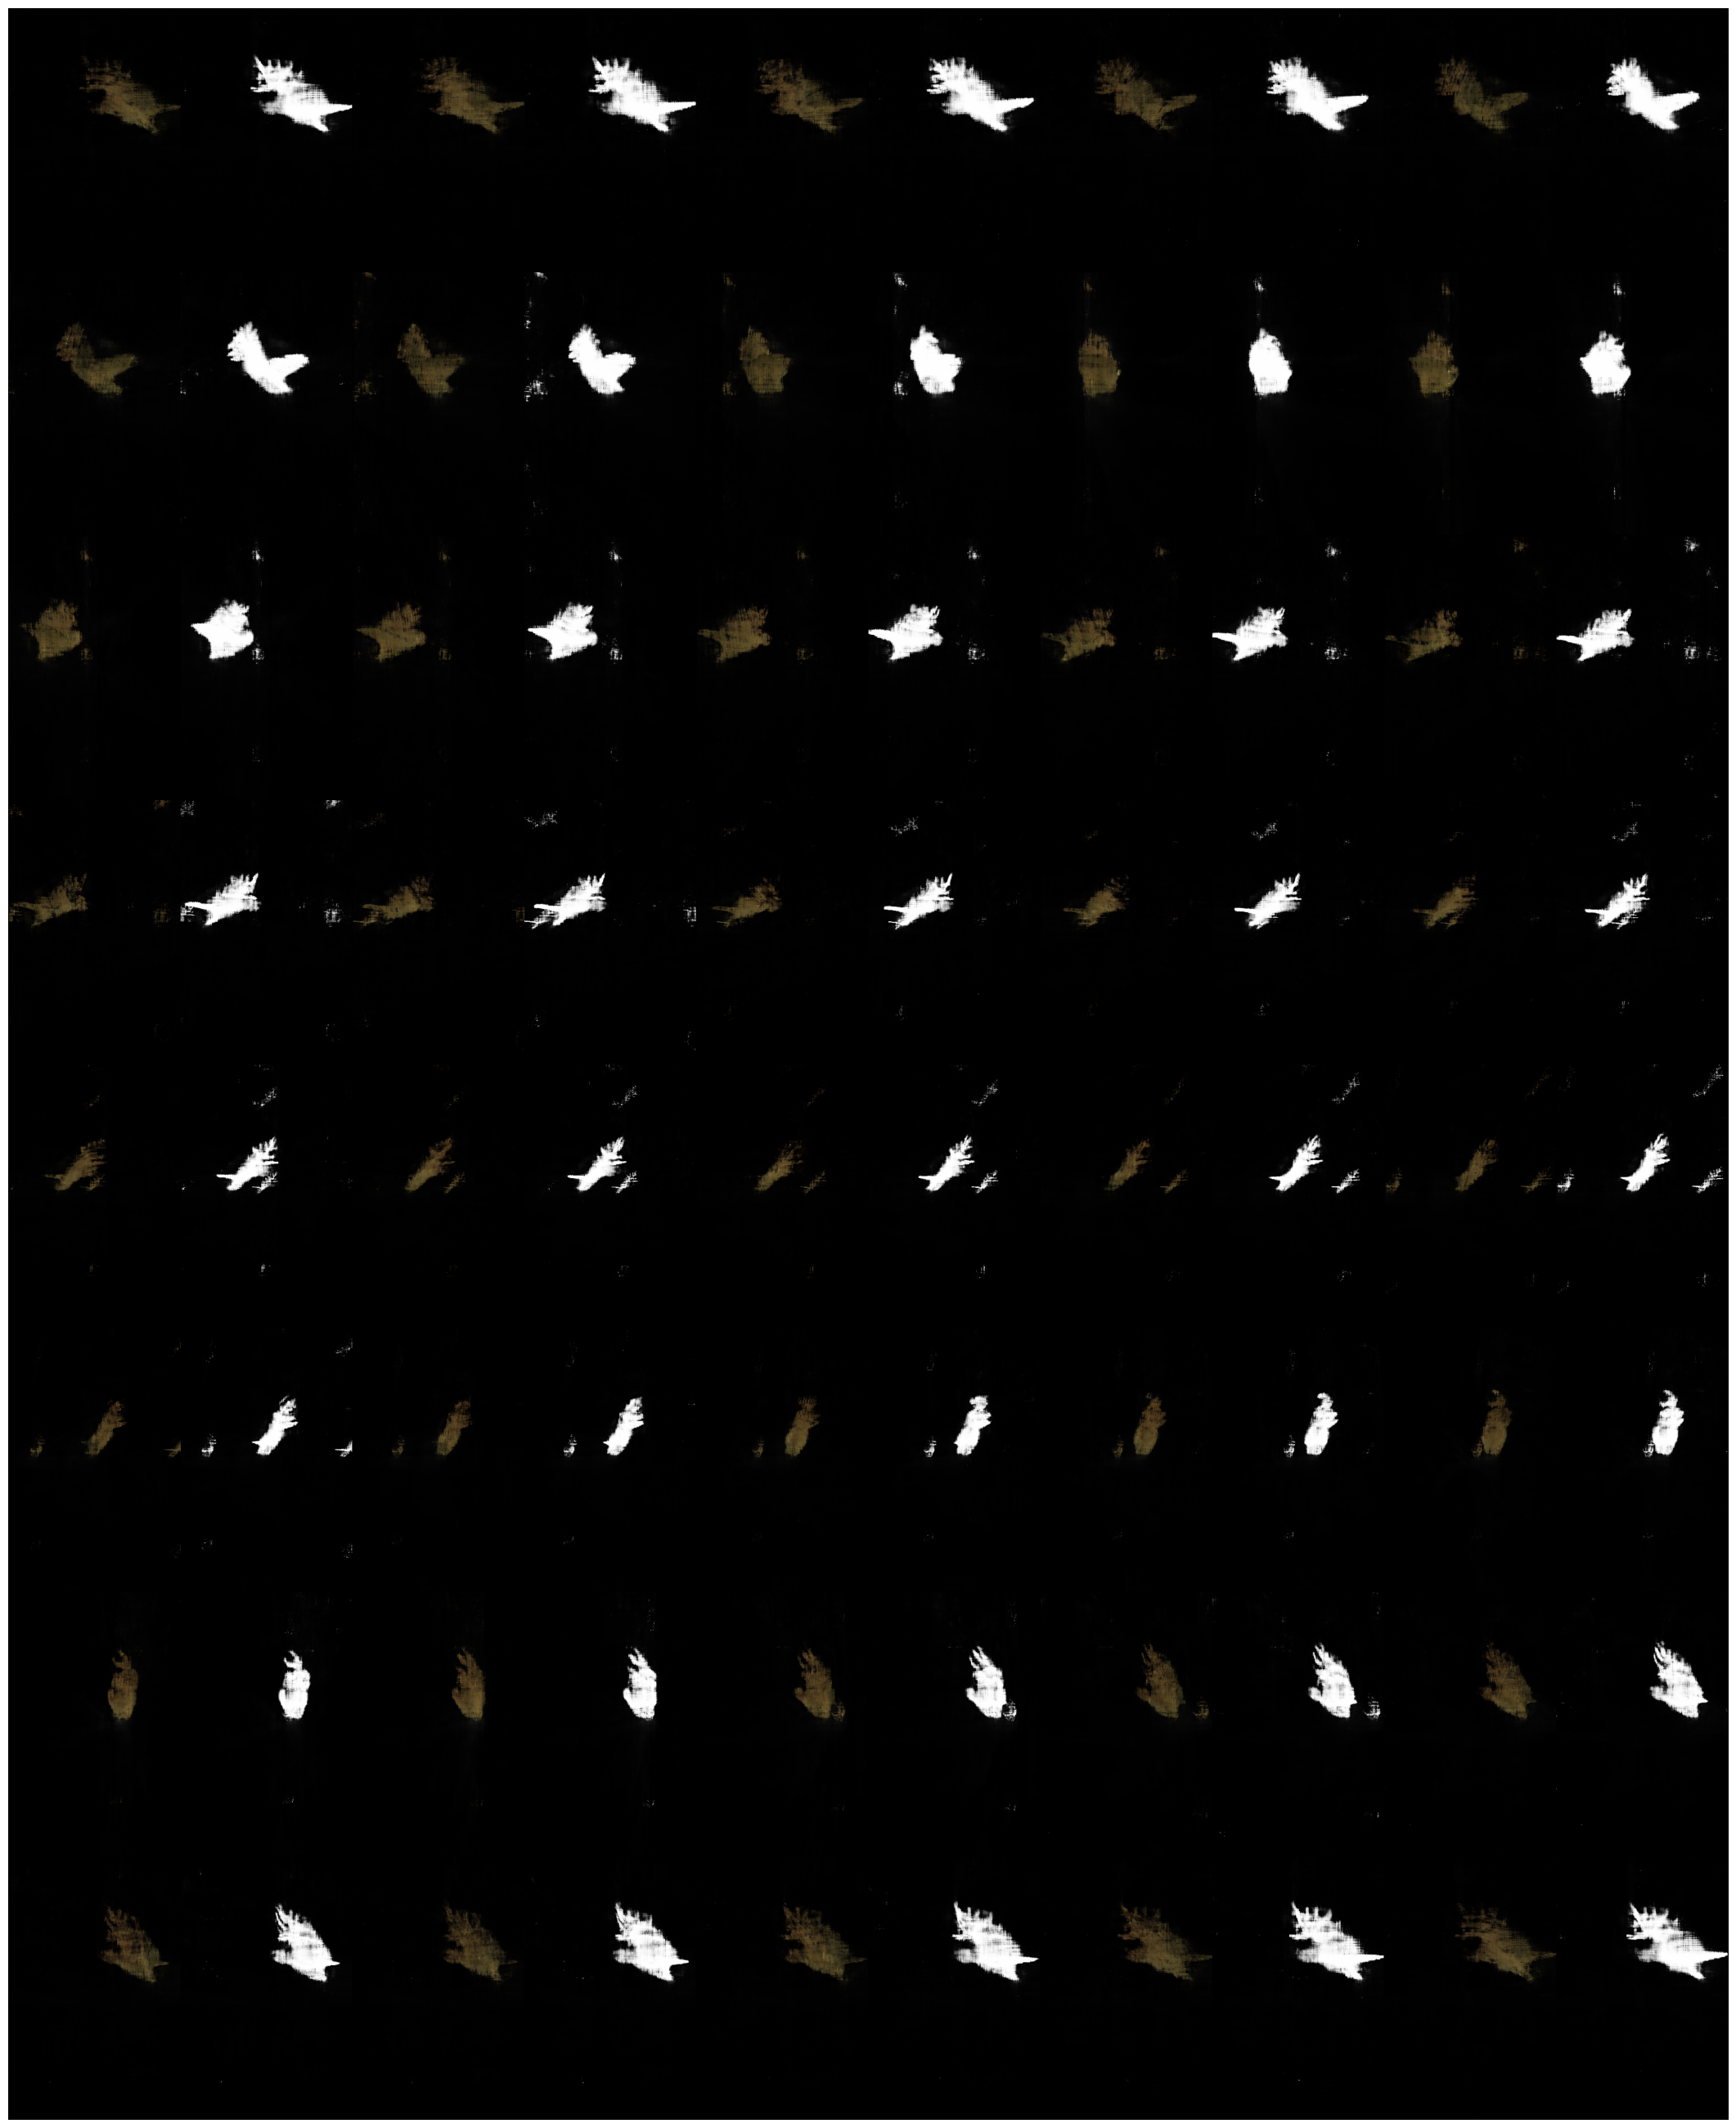

In [8]:
import torchvision
import matplotlib as mpl

%matplotlib inline
grid = torchvision.utils.make_grid(model.test_images, nrow=5)

depth, width, height = grid.shape
print(width, height)

dpi = mpl.rcParams['figure.dpi']

# What size does the figure need to be in inches to fit the image?
figsize = width / float(dpi), height / float(dpi)


# Create a figure of the right size with one axes that takes up the full figure
fig = plt.figure(figsize=figsize)
# Hide spines, ticks, etc.

plt.imshow(grid.permute(1, 2, 0).to('cpu').numpy())
plt.axis('off')

# save image grid using opencv
torchvision.utils.save_image(grid, '/home/azhuavlev/PycharmProjects/ml-neuman_mano/pytorch3d_nerf/canonical_space.png')

In [23]:
# show 5 random images from model.test_images in original resolution
import random
import torchvision
import matplotlib as mpl
import PIL


%matplotlib inline

images = model.test_images
images = torch.stack(images)
# save each image in images folder
for i in range(images.shape[0]):
    torchvision.utils.save_image(images[i], '/home/azhuavlev/PycharmProjects/ml-neuman_mano/pytorch3d_nerf/images/{}.png'.format(i))


In [11]:
camera_params, images, silhouettes, manos = can_dataset[0:1]

batch_cameras = FoVPerspectiveCameras(
    R=camera_params['R'],
    T=camera_params['t'],
    znear=camera_params['znear'],
    zfar=camera_params['zfar'],
    device=torch.device("cuda"),
)
model = model.to('cuda')

with torch.no_grad():
    opacity, color = model.get_nerf_output(
        camera=batch_cameras,
    )

torch.Size([1, 512, 334, 96, 1]) torch.Size([1, 512, 334, 96, 3])


In [15]:
print('fraction occupied', np.mean(opacity.cpu().numpy() > 0.1))

fraction occupied 0.0018837447175960578


In [17]:
torch.cuda.empty_cache()

In [ ]:
# plot 'verts'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
print(example[3]['verts'].shape)

%matplotlib inline
ax.scatter(example[3]['verts'][0, :, 0], example[3]['verts'][0, :, 1], example[3]['verts'][0, :, 2])

import mano_pytorch3d
hand_model = mano_pytorch3d.MANOCustom(
            model_path='/home/azhuavlev/Desktop/Data/models/mano/MANO_LEFT.pkl',
            is_rhand=False,
            use_pca=False,
        )

ver = hand_model.forward_pytorch3d(
    betas=example[3]['shape'],
    global_orient=example[3]['root_pose'],
    hand_pose=example[3]['hand_pose'],
    transl=example[3]['trans']
)
ax = fig.add_subplot(122, projection='3d')
ax.scatter(ver[0, :, 0], ver[0, :, 1], ver[0, :, 2], c='r')

In [ ]:
import warp_points

%matplotlib notebook
posed_verts = ver
Ts = example[3]['Ts']

zero_pose_verts = hand_model.forward_pytorch3d(
    betas=torch.zeros_like(example[3]['shape']),
    global_orient=torch.zeros_like(example[3]['root_pose']),
    hand_pose=torch.zeros_like(example[3]['hand_pose']),
    transl=torch.zeros_like(example[3]['trans'])
)

warped_points, warped_dirs = warp_points.warp_points(
    posed_verts,
    posed_verts,
    Ts
)
print(warped_points)
print(zero_pose_verts)

In [ ]:
# visualize warped points on one plot, and zero pose verts on another
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
ax.scatter(posed_verts[0, :, 0], posed_verts[0, :, 1], posed_verts[0, :, 2], c='r')
ax = fig.add_subplot(132, projection='3d')
ax.scatter(warped_points[0, :, 0], warped_points[0, :, 1], warped_points[0, :, 2], c='r')
ax = fig.add_subplot(133, projection='3d')
ax.scatter(zero_pose_verts[0, :, 0], zero_pose_verts[0, :, 1], zero_pose_verts[0, :, 2], c='r')


In [ ]:
# TODO visualize sampled rays using multinomial sampler

In [73]:
import torchvision
with torch.no_grad():
    model = model.to('cuda')
    test_images = []
    for batch in tqdm(test_loader):
        # put all the data of list on GPU

        campos = batch[0][0]


        break

        batch = [t.to('cuda') for t in batch]


        result = model.visualize_batch(batch)
        test_images.append(result)

%matplotlib inline

grid = torchvision.utils.make_grid(test_images, nrow=5)
plt.imshow(grid.permute(1, 2, 0).to('cpu').numpy())

plt.show()

  0%|          | 0/12 [00:00<?, ?it/s]

[tensor([[[ 0.5309,  0.0848, -0.8432],
         [ 0.4053,  0.8484,  0.3405],
         [ 0.7442, -0.5225,  0.4161]]]), tensor([[ 0.9078, -0.3592,  0.6427]]), tensor([[[[0.0196, 0.0118, 0.0235],
          [0.0196, 0.0118, 0.0235],
          [0.0196, 0.0118, 0.0235],
          ...,
          [0.0235, 0.0235, 0.0157],
          [0.0235, 0.0235, 0.0157],
          [0.0235, 0.0235, 0.0157]],

         [[0.0196, 0.0118, 0.0235],
          [0.0196, 0.0118, 0.0235],
          [0.0196, 0.0118, 0.0235],
          ...,
          [0.0235, 0.0235, 0.0157],
          [0.0235, 0.0235, 0.0157],
          [0.0235, 0.0235, 0.0157]],

         [[0.0196, 0.0118, 0.0235],
          [0.0196, 0.0118, 0.0235],
          [0.0196, 0.0118, 0.0235],
          ...,
          [0.0235, 0.0235, 0.0157],
          [0.0275, 0.0275, 0.0196],
          [0.0275, 0.0275, 0.0196]],

         ...,

         [[0.0196, 0.0118, 0.0235],
          [0.0196, 0.0118, 0.0235],
          [0.0196, 0.0118, 0.0235],
          ...,
      

RuntimeError: stack expects a non-empty TensorList

torch.Size([10, 256, 167, 4])
torch.Size([10, 3, 256, 167])


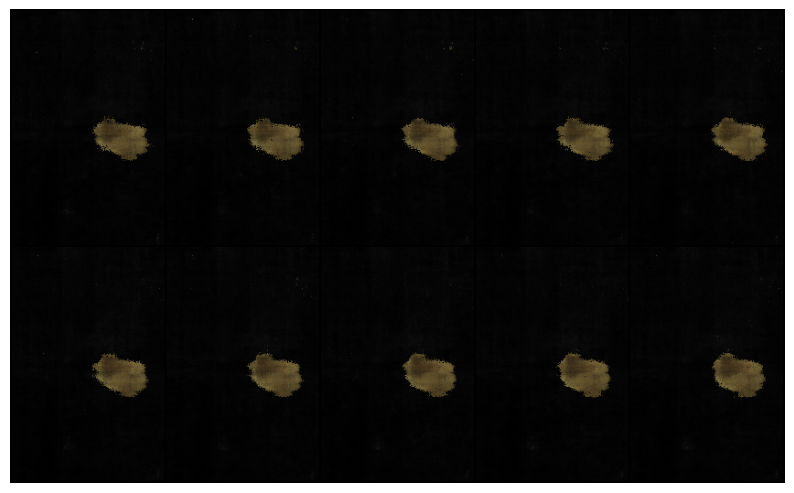

In [100]:
with torch.no_grad():
    example = next(iter(train_loader))

    R_mat = example[0][0]
    T_mat = example[1][0]

    img = example[2][0]
    depth = example[3][0]

    # print(camrot, campos)

    # create T matrices rotating around the original T_mat
    factors = torch.linspace(0.9, 1, 10, dtype=torch.float32)

    # multiply the T matrices by the factors
    # T_mats = torch.stack([T_mat * factor for factor in factors])

    T_mats = torch.repeat_interleave(T_mat.unsqueeze(0), 10, dim=0)

    T_mats[:, 2] = T_mats[:, 2] * factors

    R_mats = torch.stack([R_mat for _ in factors])

    images = torch.stack([img for _ in factors])
    depths = torch.stack([depth for _ in factors])

    # batches = torch.stack([R_mats, T_mats, images, depths])

    model = model.to('cuda')

    # batches = [t.to('cuda') for t in batches]

    batch_cameras = FoVPerspectiveCameras(
        R=R_mats,
        T=T_mats,
        znear=model.min_depth,
        zfar=model.volume_extent_world,
        device=model.device,
    )

    # Render using the grid renderer and the
    # batched_forward function of neural_radiance_field.
    rendered_image_silhouette, _ = model.renderer_grid(
        cameras=batch_cameras,
        volumetric_function=model.neural_radiance_field.batched_forward
    )
    # Split the rendering result to a silhouette render
    # and the image render.
    print(rendered_image_silhouette.shape)
    rendered_images = rendered_image_silhouette[..., :3]
    rendered_silhouettes = rendered_image_silhouette[..., 3]

    # reshape to (B x C x H x W)
    rendered_images = rendered_images.permute(0, 3, 1, 2)

    print(rendered_images.shape)

grid = torchvision.utils.make_grid(rendered_images, nrow=5)

# set figure size
plt.figure(figsize=(10, 10))
plt.imshow(grid.to('cpu').numpy().transpose(1, 2, 0))
plt.axis('off')

plt.show()


In [27]:
model.device

device(type='cpu')

In [153]:
# 3000 iterations take ~20 min on a Tesla M40 and lead to
# reasonably sharp results. However, for the best possible
# results, we recommend setting n_iter=20000.
n_iter = 30000


show_idx = torch.randperm(len(target_cameras))[:1]
show_full_render(
    neural_radiance_field,
    FoVPerspectiveCameras(
        R=target_cameras.R[show_idx],
        T=target_cameras.T[show_idx],
        znear=target_cameras.znear[show_idx],
        zfar=target_cameras.zfar[show_idx],
        aspect_ratio=target_cameras.aspect_ratio[show_idx],
        fov=target_cameras.fov[show_idx],
        device=device,
    ),
    target_images[show_idx][0],
    target_silhouettes[show_idx][0],
    loss_history_color,
    loss_history_sil,
    renderer_grid=renderer_grid,
    fig=fig,
    ax=ax,
)

AttributeError: 'Axes3D' object has no attribute 'ravel'

In [172]:
torch.cuda.empty_cache()

In [53]:
import torchvision

def plot_results(n_cameras):
    with torch.no_grad():

        # choose a random subset of cameras
        cameras_choice = torch.randperm(len(target_cameras))[:n_cameras]
        images_silhouettes = []

        for camera_index in range(len(cameras_choice)):
            show_idx = cameras_choice[camera_index:camera_index+1]

            camera = FoVPerspectiveCameras(
                R=target_cameras.R[show_idx],
                T=target_cameras.T[show_idx],
                znear=target_cameras.znear[show_idx],
                zfar=target_cameras.zfar[show_idx],
                aspect_ratio=target_cameras.aspect_ratio[show_idx],
                fov=target_cameras.fov[show_idx],
                device=device,
            )
            # Render using the grid renderer and the
            # batched_forward function of neural_radiance_field.
            rendered_image_silhouette, _ = renderer_grid(
                cameras=camera,
                volumetric_function=neural_radiance_field.batched_forward
            )
            # Split the rendering result to a silhouette render
            # and the image render.
            rendered_image, rendered_silhouette = (
                rendered_image_silhouette[0].split([3, 1], dim=-1)
            )

            # concatenate the rendered image and the silhouette.
            # print(rendered_image.shape, rendered_silhouette.shape)
            # convert rendered silhouette to rgb
            rendered_silhouette = torch.cat([rendered_silhouette, rendered_silhouette, rendered_silhouette], dim=-1)

            original_image = target_images[show_idx][0]

            # downscale the original image to the size of the rendered image

            original_image = original_image.permute(2, 0, 1)

            original_image = torch.nn.functional.interpolate(original_image[None, ...], size=rendered_image.shape[:2], mode='bilinear', align_corners=False)[0]

            original_image = original_image.permute(1, 2, 0)



            # print(original_image.shape)


            concatenated = torch.cat([
                # original_image,
                rendered_image,
                rendered_silhouette
            ], dim=1)
            # transpose (H, W, C) to pytorch image format
            concatenated = concatenated.permute(2, 0, 1)
            images_silhouettes.append(
                concatenated
                                      )


    grid = torchvision.utils.make_grid(images_silhouettes, nrow=5)

    # plot the grid
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

plot_results(10)

<IPython.core.display.Javascript object>

# Debugging

In [ ]:
neural_radiance_field(0, 0, 0)

In [19]:
with torch.no_grad():

    batch_idx = torch.randperm(len(target_cameras))[:6]

    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R=target_cameras.R[batch_idx],
        T=target_cameras.T[batch_idx],
        znear=target_cameras.znear[batch_idx],
        zfar=target_cameras.zfar[batch_idx],
        aspect_ratio=target_cameras.aspect_ratio[batch_idx],
        fov=target_cameras.fov[batch_idx],
        device=device,
    )

    ray_bundle = raysampler_grid(batch_cameras)

    from pytorch3d.renderer import ray_bundle_to_ray_points
    rays_points_world = ray_bundle_to_ray_points(ray_bundle).cpu().numpy().reshape(-1, 3)[::]

    print(ray_bundle.origins.shape, ray_bundle.directions.shape)

    # ray_bundle = RayBundle(
    #                     origins=ray_bundle.origins.reshape(-1, 3)[::1000],
    #                     directions=ray_bundle.directions.reshape(-1, 3)[::1000],
    #                     lengths=ray_bundle.lengths.reshape(-1, 32)[::1000],
    #                     xys=None,
    #                 )


    opacity, color = neural_radiance_field.batched_forward(ray_bundle)
    print(opacity.shape, color.shape)

    opacity = opacity.cpu().numpy().reshape(-1, 1)[::]
    color = color.cpu().numpy().reshape(-1, 3)[::]

    print(opacity.shape, color.shape)

    # get indices of opacities > 0.001
    opacity_indices = np.where(opacity > 0.001)[0]
    non_white = np.where(np.linalg.norm(color, axis=1) < 0.99)[0]


    # how many opacities are > 0.001?
    print('opacity_indices', len(opacity_indices))
    # print('color', color.shape)

    # # get norm of color
    # color_norm = np.linalg.norm(color, axis=1)
    #
    # print('color_norm', color_norm.shape)

    # which points have non-white color?
    # non_white = np.where(
    #     color_norm[opacity_indices] < 0.99
    # )[0]
    print('non_white', len(non_white))

    indices_both = np.intersect1d(opacity_indices, non_white)

    print('indices_both', len(indices_both))

    # plot ray_bundle.origins + ray_bundle.directions as 3d points
    %matplotlib notebook
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    import numpy as np

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # visualize ray_points_world with color and opacity, where opacity > 0.001
    ax.scatter(rays_points_world[indices_both, 0], rays_points_world[indices_both, 1], rays_points_world[indices_both, 2], c=color[indices_both, :], alpha=opacity[indices_both, :])



torch.Size([6, 256, 167, 3]) torch.Size([6, 256, 167, 3])
torch.Size([6, 256, 167, 32, 1]) torch.Size([6, 256, 167, 32, 3])
(8208384, 1) (8208384, 3)
opacity_indices 2008994
non_white 188487
indices_both 165492


<IPython.core.display.Javascript object>

In [40]:
animations = []
with torch.no_grad():
    for camera_id in range(10):
        n_frames = 30

        # logRs = torch.zeros(n_frames, 3, device=device)
        # logRs[:, 1] = torch.linspace(-3.14, 3.14, n_frames, device=device)
        # Rs = so3_exp_map(logRs)
        #
        # Ts = torch.zeros(n_frames, 3, device=device)
        # Ts[:, 2] = 2.7
        # Ts[:, 1] = torch.cos(torch.linspace(0, 3.14, n_frames, device=device))
        # Ts[:, 0] = torch.sin(torch.linspace(0, 3.14, n_frames, device=device))

        # Rs = torch.ra

        # camera_id = 9
        R=target_cameras.R[camera_id:camera_id+1]
        T=target_cameras.T[camera_id:camera_id+1]

        # generate camera trajectory using R and T
        # Rs = so3_exp_map(torch.linspace(0, 3.14, n_frames, device=device)[:, None, None] * R)

        # copy R n_frames times
        Rs = torch.repeat_interleave(R, n_frames, dim=0)

        # create Ts by rotating around T
        Ts = torch.zeros(n_frames, 3, device=device)
        Ts[:, 2] = 2.7 * torch.cos(torch.linspace(-3.14, 3.14, n_frames, device=device))
        # Ts[:, 1] = torch.cos(torch.linspace(-3.14, 3.14, n_frames, device=device))
        # Ts[:, 0] = torch.sin(torch.linspace(-3.14, 3.14, n_frames, device=device))
        Ts = Ts + T



        frames = []
        print('Rendering rotating NeRF ...')
        for R, T in zip(tqdm(Rs), Ts):
            camera = FoVPerspectiveCameras(
                R=R[None],
                T=T[None],
                znear=target_cameras.znear[0],
                zfar=target_cameras.zfar[0],
                aspect_ratio=target_cameras.aspect_ratio[0],
                fov=target_cameras.fov[0],
                device=device,
            )
            # Note that we again render with `NDCMultinomialRaysampler`
            # and the batched_forward function of neural_radiance_field.
            frames.append(
                renderer_grid(
                    cameras=camera,
                    volumetric_function=neural_radiance_field.batched_forward,
                )[0][0][..., :3].cpu().numpy()
            )

    # show frames as gif
        from IPython.display import HTML
        from matplotlib import animation

        fig = plt.gcf()
        plt.axis('off')
        ims = [[plt.imshow(frame, animated=True)] for frame in frames]
        ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                        repeat_delay=100)

        # plt.clf()
        vid = HTML(ani.to_jshtml())
        animations.append(vid)

        display(vid)
        break
    # plt.clf()


Rendering rotating NeRF ...


  0%|          | 0/30 [00:00<?, ?it/s]